### Import things

In [1]:
import air as air
import matcher as match
import numpy as np
import glob
import matplotlib.pyplot as plt
import pandas as pd

### Load in our data using existing functions

In [2]:
sensor_data = air.files_to_dataframe(glob.glob('../data/purple_air/*'))
matched_ses_data = match.station_matcher(sensor_data)

### Make a new column that is the # of sensors

In [3]:
def count_sensors(files_string):
    '''Helper function to count the number of sensor files in each long string
    '''
    
    new_files_string = str(files_string)
    counts = 0
    if new_files_string == 'nan':
        return 0
    else:
        counts = new_files_string.count(",") + 1
        return counts

#Note I divide by 4 as it has loaded 4 datastreams for each sensor
matched_ses_data['sensor_counts'] = matched_ses_data.apply(lambda row:
                                                           count_sensors(row['sensor_file_names']), axis=1) /4

matched_data_dataframe = pd.DataFrame(matched_ses_data)

## Now plot stuff!

Text(0.5, 1.0, 'Sensor counts by census tract')

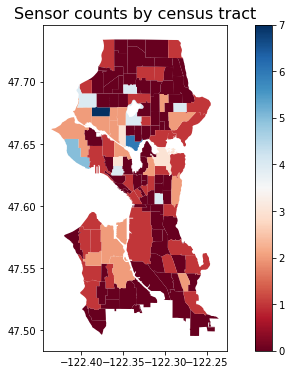

In [4]:
fig, ax = plt.subplots(figsize=(10, 6))
counts_plot = matched_ses_data.plot(column='sensor_counts', cmap='RdBu', legend=True, ax=ax)
plt.title('Sensor counts by census tract', fontsize=16)

### Some info on what different data exists in the SES dataset
All info is here: https://data-seattlecitygis.opendata.arcgis.com/datasets/racial-and-social-equity-composite-index <br>
Note: Maybe we should rename some of these! I also may be wrong on what some of these are <br>
RACE_ELL_O: Percentage of people of color <br>
SOCIOECONO: A composite of different socioeconomic things <br>
COMPOSITE_: The composite of everything <br>
HEALTH_PER: A composite index of different health metrics

### Scatter plot to see how the number of sensors in a plot relates to different SES metrics
Note: The size of each mark is scaled by the number of such census tracts. So for tracts with lots of sensors we might only have n=1

Text(0.5, 0, 'Sensors in census tract')

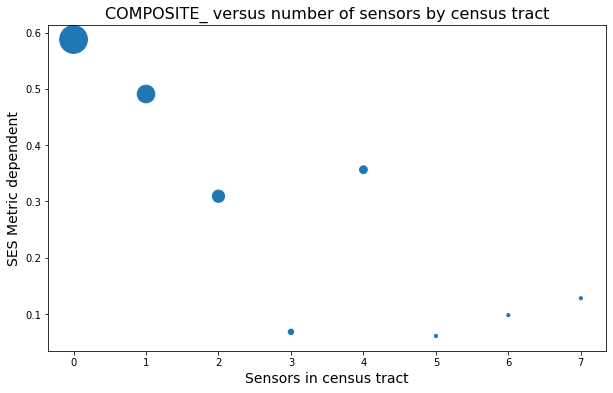

In [5]:
which_metric = 'COMPOSITE_'
fig, ax = plt.subplots(figsize=(10, 6))
grouped = matched_data_dataframe.groupby('sensor_counts')[which_metric].mean()
counts = matched_data_dataframe.groupby('sensor_counts')['OBJECTID'].count()

plt.scatter(range(8), grouped, s=counts*10)
plt.title(which_metric + ' versus number of sensors by census tract', fontsize=16)
plt.ylabel('SES Metric dependent', fontsize=14)
plt.xlabel('Sensors in census tract', fontsize=14)